In [134]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 50)
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')
# display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML(open("../shared-resources/jupyter.css", "r").read()))
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [3]:
df = pd.read_csv('../shared-resources/time_series/time-series-2010.csv', index_col=0, header=0, parse_dates=True)
del df['open'], df['close'], df['2010-07-19 00:00:00'], df['high'], df['low']
df.to_csv('../shared-resources/time_series/time-series-clean_2010.csv')

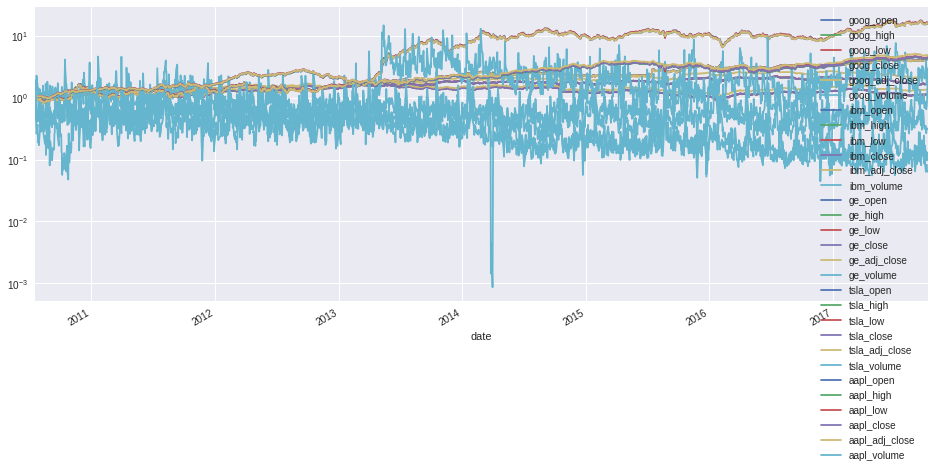

In [4]:
ax = df.plot(logy=True, figsize=(16, 6))

In [142]:
# X including mean

X = np.empty((1816, 5))
for i in range(5):
    X[:, i] = df['goog_close'][4-i:-i-1].values
Xmean = np.mean(X, axis=1)
Xmean = Xmean.reshape(-1, 1)
y = (df['goog_close'][5:].diff() > 0).values.astype(int)
y_price = df['goog_close'][5:].values.astype('float32')
print(Xmean.shape)
print(X.shape)
X = np.concatenate([Xmean, X], axis=1)

In [202]:
# X minus mean (per week)

X = np.empty((1816, 5))
for i in range(5):
    X[:, i] = df['goog_close'][4-i:-i-1].values
Xmean = np.mean(X, axis=1)
y = (df['goog_close'][5:].diff() > 0).values.astype(int)
y_price = df['goog_close'][5:].values.astype('float32')
for col in range(X.shape[1]):
    X[:, col] = np.subtract(X[:, col], Xmean)
X = np.multiply(X, 50.0)

In [204]:
print(Xmean.shape)
print(X.shape)

(1816,)
(1816, 5)


In [205]:
Xtrain = X[:1500]
ytrain = y[:1500]
y_price_train = y_price[:1500]
Xtest = X[1500:]
ytest = y[1500:]
y_price_test = y_price[1500:]

In [206]:
for i in range(10):
    print(Xtrain[i], ytrain[i], y_price_train[i])

[ 1.07597807  0.51289198 -0.27113921  0.16753229 -1.48526314] 0 1.04889
[ 0.47020462  0.58711113  0.02402504 -0.76000615 -0.32133465] 1 1.05674
[ 0.62593881  0.23338626  0.35029277 -0.21279332 -0.99682451] 0 1.03898
[-0.40906951  0.47900006  0.08644751  0.20335402 -0.35973207] 1 1.04035
[-0.34428764 -0.41293062  0.47513895  0.0825864   0.19949291] 0 1.04005
[-0.24754446 -0.2325283  -0.30117128  0.58689829  0.19434574] 1 1.05198
[ 0.31790311 -0.2784338  -0.26341764 -0.33206062  0.55600895] 0 1.05073
[ 0.31575723  0.37796604 -0.21837087 -0.20335471 -0.27199769] 1 1.0861
[ 1.61311127 -0.15552001 -0.0933112  -0.68964811 -0.67463195] 1 1.08992
[ 1.30829302  1.11738003 -0.65125125 -0.58904244 -1.18537935] 0 1.07302


In [207]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
lr.score(Xtest, ytest)

0.53164556962025311

In [211]:
for i in range(10):
    print(lr.predict(Xtest[i].reshape(1, 5)), ytest[i])

[1] 1
[1] 1
[0] 0
[0] 1
[0] 0
[1] 1
[1] 1
[0] 1
[0] 0
[0] 1


In [212]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(Xtrain, y_price_train)
linear.score(Xtest, y_price_test)

-27.03094104678479

In [214]:
for i in range(1):
    p = linear.predict(Xtest[i].reshape(1, 5))[0]
    print('pred_up:', p > Xtest[i, -1], 'up:', y_price_test[i] > Xtest[i, -1], 'prediction_error > flat?', abs(p-y_price_test[i]) > abs(Xtest[i,-1]-y_price_test[i]))

pred_up: True up: True prediction_error > flat? False


In [216]:
df_linear = pd.DataFrame.from_records(Xtest, columns=['d5', 'd4', 'd3', 'd2', 'd1'])
df_linear['next_day_up'] = ytest
df_linear['predict_up'] = lr.predict(Xtest)
df_linear['predict_correct'] = (df_linear.predict_up == df_linear.next_day_up).astype(int)
df_linear['next_day_price'] = y_price_test
df_linear['predict_price'] = linear.predict(Xtest)
df_linear['predict_error'] = df_linear.predict_price - df_linear.next_day_price
df_linear['flat_error'] = df_linear.d5 - df_linear.next_day_price
df_linear['predict_error_lt_flat_error'] = (df_linear.predict_error < df_linear.flat_error).astype(int)

In [217]:
print(df_linear.predict_correct.sum()/len(df_linear))
print(df_linear.predict_error_lt_flat_error.sum()/len(df_linear))
df_linear.head()

0.53164556962
0.193037974684


,d5,d4,d3,d2,d1,next_day_up,predict_up,predict_correct,next_day_price,predict_price,predict_error,flat_error,predict_error_lt_flat_error
0,1.521263,-0.696082,-0.175744,-0.784597,0.135159,1,1,1,3.087824,1.983349,-1.104476,-1.566561,0
1,2.878012,0.835550,-1.381795,-0.861457,-1.470310,1,1,1,3.111790,1.993664,-1.118126,-0.233778,1
2,2.966962,1.768694,-0.273768,-2.491113,-1.970775,0,0,1,3.095985,2.032970,-1.063015,-0.129023,1
3,1.347240,2.137458,0.939190,-1.103272,-3.320616,1,0,0,3.113128,2.015026,-1.098102,-1.765889,0
4,1.099387,0.242239,1.032457,-0.165811,-2.208273,0,0,1,3.108378,1.961826,-1.146552,-2.008991,0


In [180]:
df_linear = pd.DataFrame.from_records(Xtrain, columns=['avg', 'd5', 'd4', 'd3', 'd2', 'd1'])
df_linear['next_day_up'] = ytrain
df_linear['predict_up'] = lr.predict(Xtrain)
df_linear['predict_correct'] = (df_linear.predict_up == df_linear.next_day_up).astype(int)
df_linear['next_day_price'] = y_price_train
df_linear['predict_price'] = linear.predict(Xtrain)
df_linear['predict_error'] = df_linear.predict_price - df_linear.next_day_price
df_linear['flat_error'] = df_linear.d5 - df_linear.next_day_price
df_linear['predict_error_lt_flat_error'] = (df_linear.predict_error < df_linear.flat_error).astype(int)

In [181]:
print(df_linear.predict_correct.sum()/len(df_linear))
print(df_linear.predict_error_lt_flat_error.sum()/len(df_linear))
df_linear.head()

0.539333333333
0.203333333333


,avg,d5,d4,d3,d2,d1,next_day_up,predict_up,predict_correct,next_day_price,predict_price,predict_error,flat_error,predict_error_lt_flat_error
0,1.029705,1.051225,1.039963,1.024282,1.033056,1.000000,0,1,0,1.048887,1.052559,0.003672,0.002338,0
1,1.039483,1.048887,1.051225,1.039963,1.024282,1.033056,1,1,1,1.056738,1.050453,-0.006285,-0.007851,0
2,1.044219,1.056738,1.048887,1.051225,1.039963,1.024282,0,1,0,1.038976,1.057899,0.018923,0.017761,0
3,1.047158,1.038976,1.056738,1.048887,1.051225,1.039963,1,1,1,1.040349,1.040153,-0.000196,-0.001373,0
4,1.047235,1.040349,1.038976,1.056738,1.048887,1.051225,0,1,0,1.040049,1.042152,0.002103,0.000300,0


1 0.4968354430379748 0.5413333333333333 0.03460049629211426
2 0.4968354430379748 0.5546666666666668 0.038275957107543945
3 0.5316455696202532 0.5546666666666668 0.04422497749328613
4 0.5126582278481012 0.5653333333333334 0.05070066452026367
5 0.5284810126582278 0.5713333333333334 0.057211875915527344
6 0.5284810126582278 0.5780000000000001 0.07286477088928223
7 0.5221518987341771 0.5806666666666667 0.07632017135620117
8 0.5253164556962026 0.5846666666666668 0.08419060707092285
9 0.5126582278481012 0.5860000000000001 0.10623598098754883
10 0.5031645569620252 0.5986666666666666 0.09869980812072754
11 0.5031645569620252 0.6013333333333335 0.11037182807922363
12 0.5379746835443039 0.6053333333333333 0.12350225448608398
13 0.5221518987341771 0.6246666666666666 0.13587141036987305
14 0.5126582278481012 0.6180000000000001 0.13607382774353027
15 0.4905063291139241 0.6386666666666666 0.14676523208618164
16 0.5 0.63 0.1483778953552246
17 0.5063291139240507 0.6306666666666666 0.16350626945495605


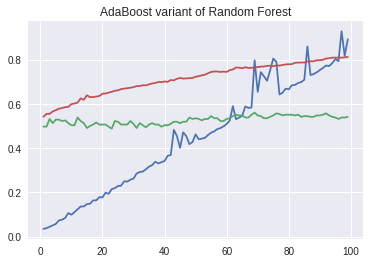

In [220]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import matplotlib.pyplot as plt

test_scores = []
train_scores = []
times = []
list_of_n_estimators = range(1,100)
for n in list_of_n_estimators: # for n_estimators in [1:15]
    temp_scores_train = []
    temp_scores_test = []
    start = time.time()
    for i in range(10):  # repeat this 5 times
        clf = GradientBoostingClassifier(n_estimators=n, learning_rate=0.6,
            max_depth=2, random_state=0, max_features=3).fit(Xtrain, ytrain)
        score = clf.score(Xtest, ytest)
        temp_scores_test.append(score)
        score = clf.score(Xtrain, ytrain)
        temp_scores_train.append(score)
    avg_score_test = float(sum(temp_scores_test))/len(temp_scores_test)
    avg_score_train = float(sum(temp_scores_train))/len(temp_scores_train)
    test_scores.append(avg_score_test)
    train_scores.append(avg_score_train)
    elapsed = time.time() - start
    times.append(elapsed)
    print(n, avg_score_test, avg_score_train, elapsed)

plt.plot(list_of_n_estimators, times)
plt.plot(list_of_n_estimators, test_scores)
plt.plot(list_of_n_estimators, train_scores)

plt.title("AdaBoost variant of Random Forest")

1 0.4430379746835443 0.526 0.02628159523010254
2 0.4462025316455696 0.5266666666666666 0.0354306697845459
3 0.4462025316455696 0.532 0.04524850845336914
4 0.4462025316455696 0.5333333333333333 0.054848670959472656
5 0.4462025316455696 0.536 0.06712031364440918
6 0.4462025316455696 0.5366666666666666 0.08278894424438477
7 0.4462025316455696 0.5373333333333333 0.08674263954162598
8 0.4462025316455696 0.5406666666666666 0.11215066909790039
9 0.4462025316455696 0.5533333333333333 0.11652278900146484
10 0.4462025316455696 0.5553333333333333 0.12499141693115234
11 0.4462025316455696 0.552 0.16801095008850098
12 0.4462025316455696 0.5533333333333333 0.26653456687927246
13 0.4525316455696203 0.5513333333333333 0.15748000144958496
14 0.4525316455696203 0.5513333333333333 0.17165422439575195
15 0.4525316455696203 0.5513333333333333 0.22603678703308105
16 0.4525316455696203 0.5386666666666666 0.2469327449798584
17 0.4525316455696203 0.5386666666666666 0.19750523567199707
18 0.4525316455696203 0.5

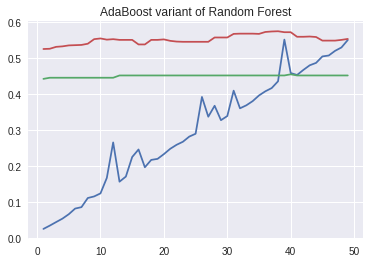

In [84]:
from sklearn.ensemble import RandomForestClassifier
import time
import matplotlib.pyplot as plt

test_scores = []
train_scores = []
times = []
list_of_n_estimators = range(1,50)
for n in list_of_n_estimators: # for n_estimators in [1:15]
    temp_scores_train = []
    temp_scores_test = []
    start = time.time()
    for i in range(5):  # repeat this 5 times
        clf = RandomForestClassifier(n_estimators=n,
            max_depth=2, random_state=0, max_features=3).fit(Xtrain, ytrain)
        score = clf.score(Xtest, ytest)
        temp_scores_test.append(score)
        score = clf.score(Xtrain, ytrain)
        temp_scores_train.append(score)
    avg_score_test = float(sum(temp_scores_test))/len(temp_scores_test)
    avg_score_train = float(sum(temp_scores_train))/len(temp_scores_train)
    test_scores.append(avg_score_test)
    train_scores.append(avg_score_train)
    elapsed = time.time() - start
    times.append(elapsed)
    print(n, avg_score_test, avg_score_train, elapsed)

plt.plot(list_of_n_estimators, times)
plt.plot(list_of_n_estimators, test_scores)
plt.plot(list_of_n_estimators, train_scores)

plt.title("AdaBoost variant of Random Forest")

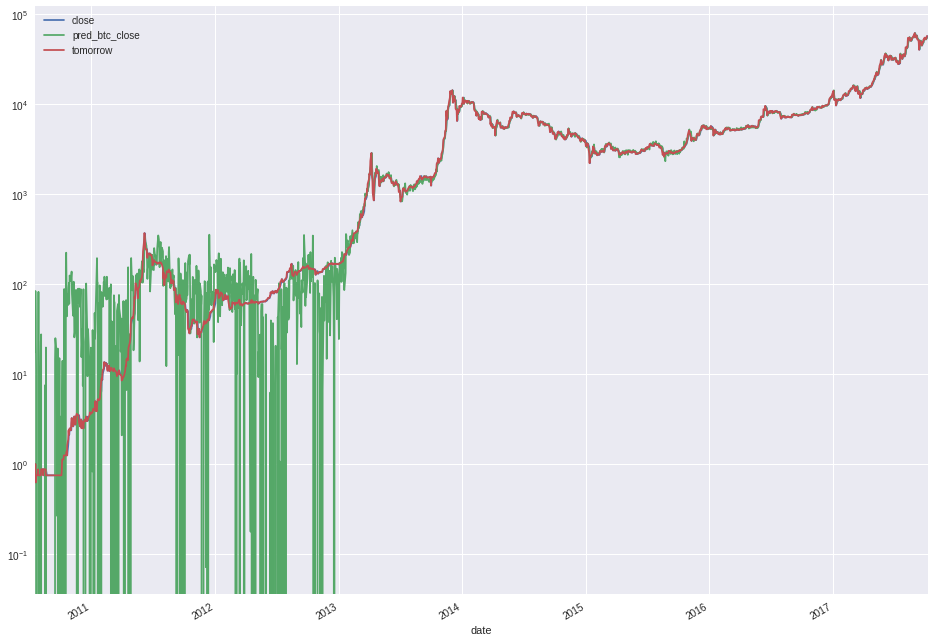

In [38]:
ax = df[['close', 'pred_btc_close', 'tomorrow']].plot(logy=True, figsize=(16, 12))

In [39]:
mpld3.display(ax.figure)

In [40]:
with open('../shared-resources/btc.html', 'w') as fout:
    fout.write(mpld3.fig_to_html(ax.figure))

In [66]:
X = df[list(df.columns)[:-3]].iloc[:-1]
y = df['close'].iloc[1:]
X = X.fillna(method='ffill')
y = y.fillna(method='ffill')

X = pd.concat([X, X.diff()], axis=1)
y = y.diff()
print(X.shape)
print(y.shape)

X = X.fillna(method='ffill')
y = y.fillna(method='ffill')

(1820, 68)
(1820,)


In [67]:
X.describe()

,goog_open,goog_high,goog_low,goog_close,goog_adj_close,goog_volume,ibm_open,ibm_high,ibm_low,ibm_close,ibm_adj_close,ibm_volume,ge_open,ge_high,ge_low,ge_close,ge_adj_close,ge_volume,tsla_open,tsla_high,tsla_low,tsla_close,tsla_adj_close,tsla_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_adj_close,aapl_volume,open,high,low,close,goog_open,goog_high,goog_low,goog_close,goog_adj_close,goog_volume,ibm_open,ibm_high,ibm_low,ibm_close,ibm_adj_close,ibm_volume,ge_open,ge_high,ge_low,ge_close,ge_adj_close,ge_volume,tsla_open,tsla_high,tsla_low,tsla_close,tsla_adj_close,tsla_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_adj_close,aapl_volume,open,high,low,close
count,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1820.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000,1819.000000
mean,2.267521,2.242657,2.265616,2.242066,2.242066,0.388666,1.326838,1.318633,1.321453,1.316070,1.419059,0.538278,1.648092,1.649199,1.654808,1.650623,1.890179,0.906599,6.964747,6.801399,6.987152,6.792191,6.792191,1.789327,2.515536,2.536742,2.599428,2.559251,2.696632,0.317097,5019.781746,5177.575397,5472.148695,5670.915453,0.001771,0.001758,0.001780,0.001774,0.001774,-0.000479,0.000077,0.000069,0.000077,0.000071,0.000196,-0.000378,0.000367,0.000366,0.000367,0.000367,0.000621,-0.000093,0.008534,0.008348,0.008707,0.008405,0.008405,0.000400,0.001837,0.001845,0.001933,0.001884,0.002155,-0.000512,26.404374,26.982836,29.572567,30.031336
std,0.905851,0.894337,0.906558,0.895985,0.895985,0.297163,0.170842,0.169262,0.170722,0.169299,0.165483,0.260942,0.319255,0.317749,0.323128,0.320054,0.479454,0.563432,4.934704,4.803498,4.964256,4.811607,4.811607,1.711352,0.880040,0.885110,0.911788,0.895477,1.028699,0.214872,8499.173585,8811.285211,9225.609083,9622.796443,0.034229,0.030143,0.031421,0.032756,0.032756,0.220946,0.014847,0.013630,0.014506,0.015382,0.016433,0.256921,0.020166,0.018305,0.021214,0.019831,0.022655,0.451564,0.235110,0.194094,0.222995,0.216534,0.216534,1.140826,0.044201,0.035273,0.041580,0.040114,0.042212,0.135563,574.920367,504.419319,664.815921,641.958156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50%,2.294498,2.270430,2.292761,2.269240,2.269240,0.327016,1.318411,1.311896,1.312612,1.310193,1.433875,0.475663,1.700478,1.702510,1.704561,1.700410,1.986323,0.779384,8.594290,8.402697,8.620459,8.374258,8.374258,1.395737,2.479970,2.500940,2.560434,2.525837,2.545766,0.267378,2623.944444,2660.277778,2900.250000,2955.000000,0.001453,0.001171,0.002426,0.000987,0.000987,-0.005175,0.000466,0.000077,0.001013,0.000231,0.000363,-0.004590,0.000683,-0.000678,0.000691,0.000684,0.000734,-0.008434,0.003276,0.000000,0.008126,0.003651,0.003651,-0.023125,0.002801,0.001401,0.004048,0.001710,0.001886,-0.004220,0.333333,0.000000,1.125000,0.250000
75%,3.064247,3.039646,3.053534,3.029228,3.029228,0.509285,1.475499,1.464105,1.468587,1.462594,1.551144,0.612084,1.872951,1.871777,1.882688,1.874829,2.229618,1.040923,10.765208,10.536854,10.827557,10.498174,10.498174,2.402584,3.152703,3.186669,3.258754,3.210970,3.457066,0.418303,6397.750000,6482.861111,7003.906250,7187.

In [68]:
y.describe()

count    1819.000000
mean       31.599918
std       645.361273
            ...     
50%         0.250000
75%        42.250000
max      8789.125000
Name: close, Length: 8, dtype: float64

In [69]:
y = y.iloc[1:]
X = X.iloc[1:]
print(X.shape)
print(y.isnull().sum())

(1819, 68)
0


In [70]:
ynull = y[y.isnull()]
ynull

Series([], Name: close, dtype: float64)

In [77]:
y


date
2010-07-21       0.125
2010-07-22      -0.375
2010-07-23       0.125
                ...   
2017-10-05    1210.375
2017-10-06     593.625
2017-10-09    2853.125
Name: close, Length: 1819, dtype: float64

In [85]:
y_pred = lr.predict(X)
df_pred = pd.DataFrame()
df_pred['pred_diff'] = y_pred
df_pred
print(y)
df_pred['true_diff'] = y.values
df_pred
y_pred[pd.isnull(y_pred)]
df_pred.isnull()

date
2010-07-21       0.125
2010-07-22      -0.375
2010-07-23       0.125
                ...   
2017-10-05    1210.375
2017-10-06     593.625
2017-10-09    2853.125
Name: close, Length: 1819, dtype: float64


,pred_diff,true_diff
0,False,False
1,False,False
2,False,False
...,...,...
1816,False,False
1817,False,False
1818,False,False


In [87]:
ax = df_pred.plot(logy=True, figsize=(16,8))
mpld3.display(ax.figure)

In [88]:
with open('../shared-resources/btc_change.html', 'w') as fout:
    fout.write(mpld3.fig_to_html(ax.figure))